In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%pylab inline
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


C:\Users\dolph\Anaconda2.0\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
russia=pd.read_csv('WAG_C_M.xls',sep=';',index_col='month',parse_dates=True,dayfirst=True)

<Figure size 1080x720 with 0 Axes>

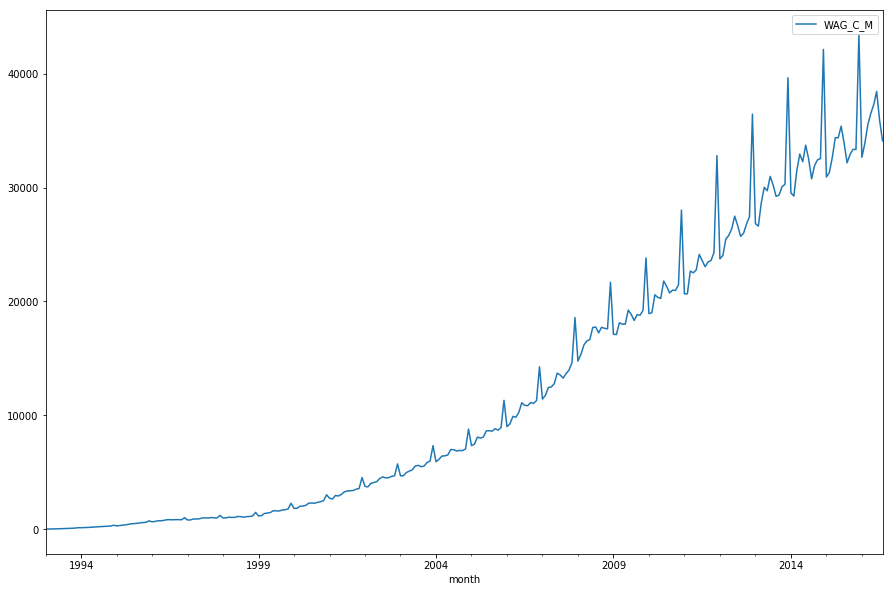

In [5]:
plt.figure(figsize(15,10))
russia.plot()

Есть повышающийся тренд, сезонность, годовой цикл. Ряд нестационарен

Проверим ряд на стационарность

In [13]:
sm.tsa.stattools.adfuller(russia.WAG_C_M)[1]

0.9918495954854735

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии

In [14]:
from scipy.stats import boxcox
russia['box'],lmbda=boxcox(russia.WAG_C_M)

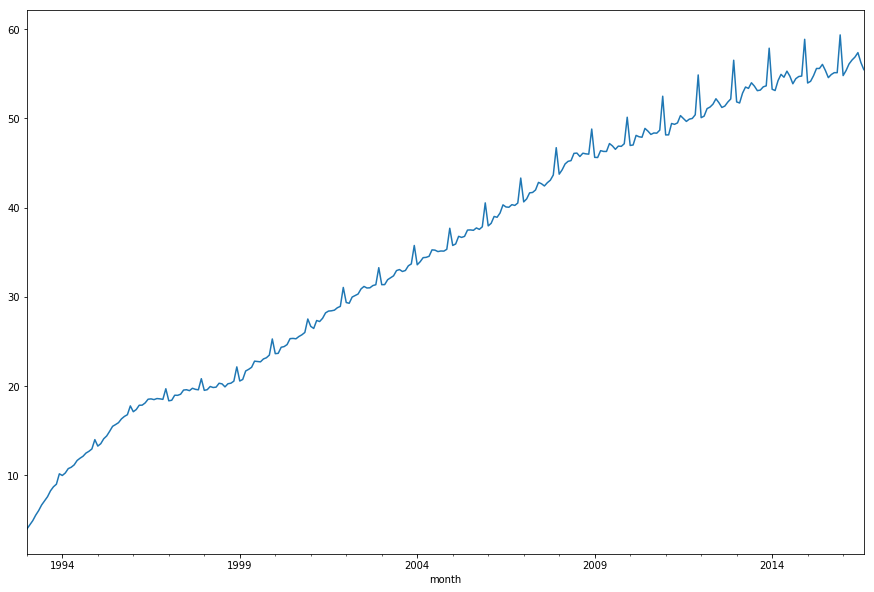

In [15]:
plt.figure(figsize(15,10))
russia.box.plot()

In [16]:
russia['diff12'] = russia.box-russia.box.shift(12)



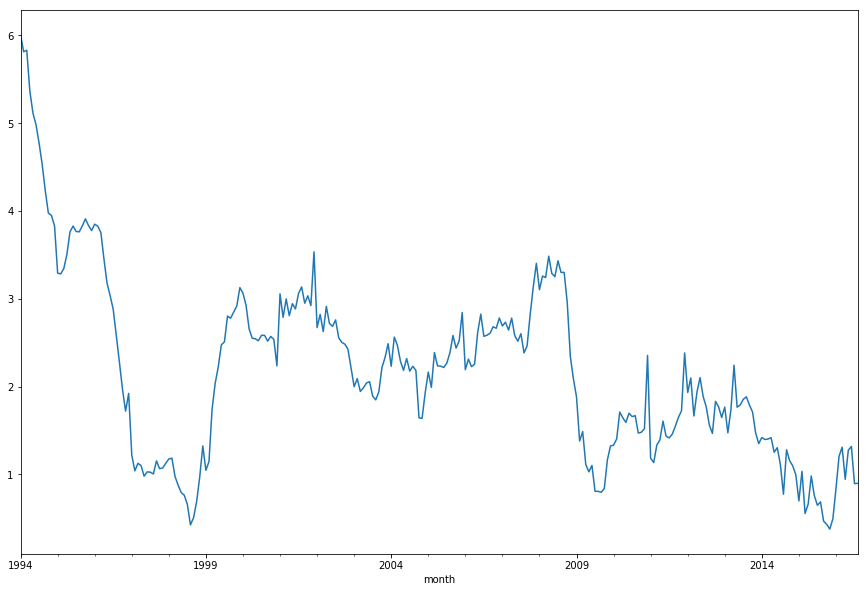

In [17]:
russia.diff12.dropna().plot()

In [19]:
sm.tsa.stattools.adfuller(russia.diff12.dropna())[1]

0.014697133494791917

Сезонное дифференцирование сделало ряд стационарным,однако,виден тренд
Сделаем еще одно дифференцирование

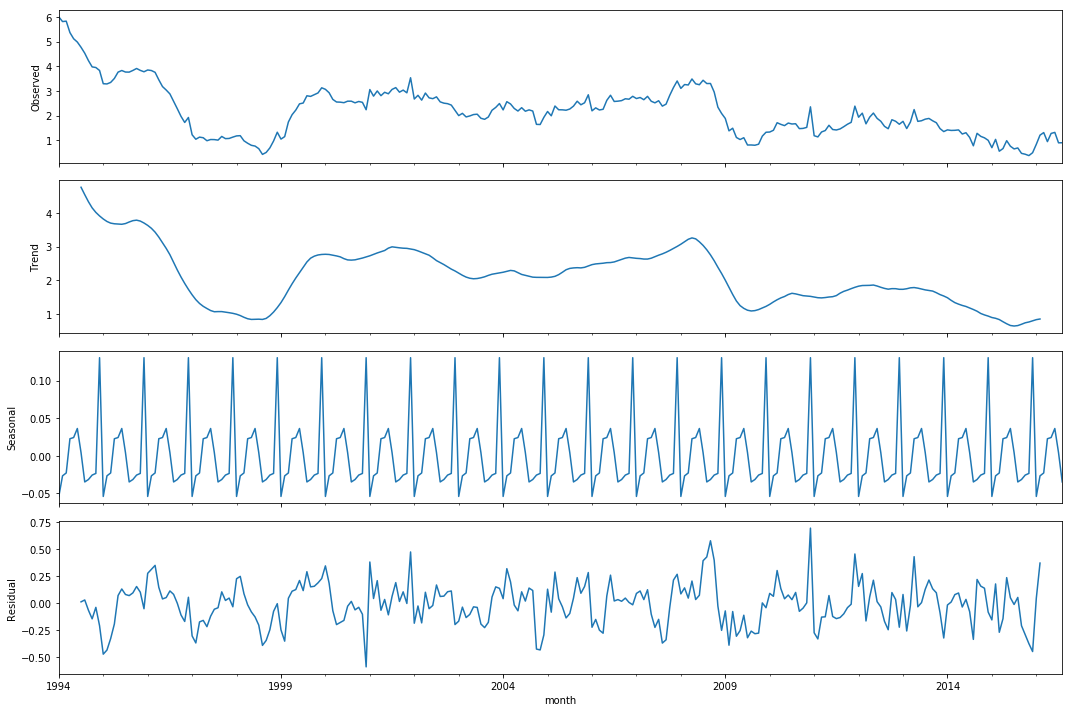

<Figure size 1080x720 with 0 Axes>

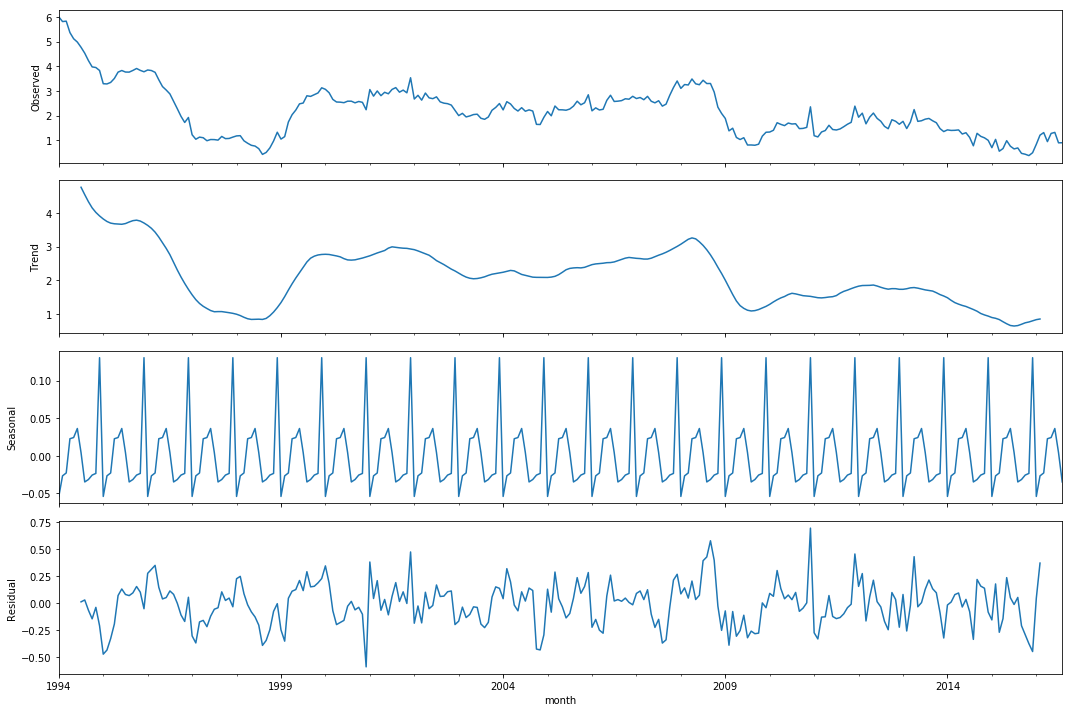

In [20]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(russia.diff12.dropna()).plot()

In [21]:
russia['diff13'] = russia.diff12-russia.diff12.shift(1)

In [25]:
sm.tsa.stattools.adfuller(russia.diff13.dropna())[1]


5.203603715821267e-08

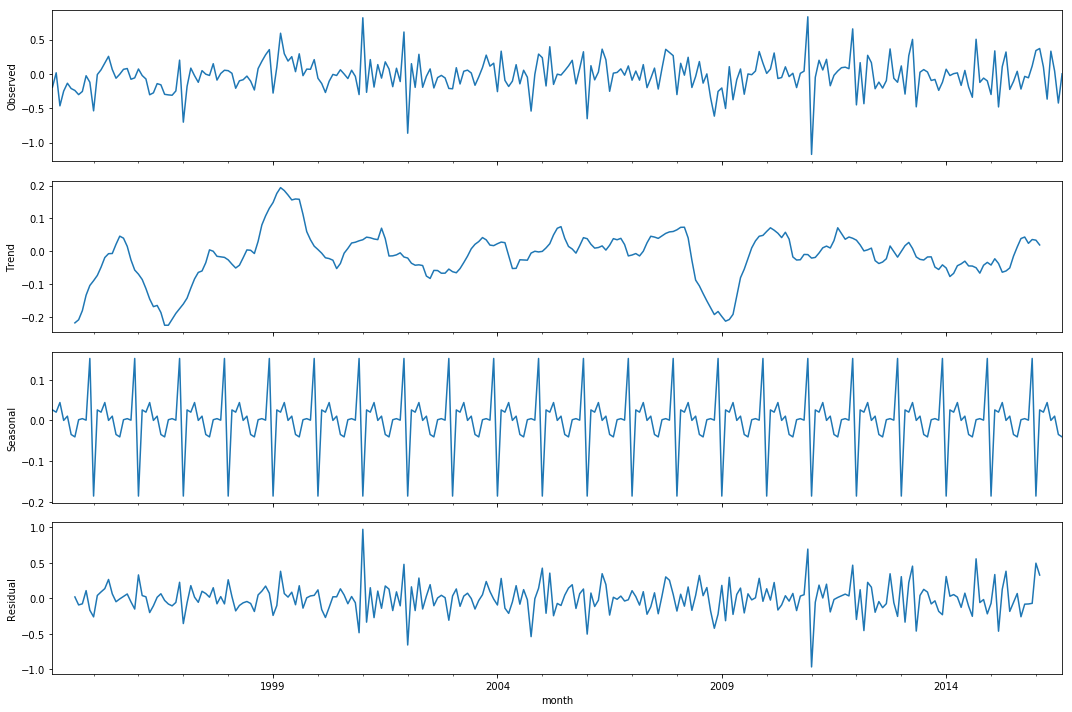

<Figure size 1080x720 with 0 Axes>

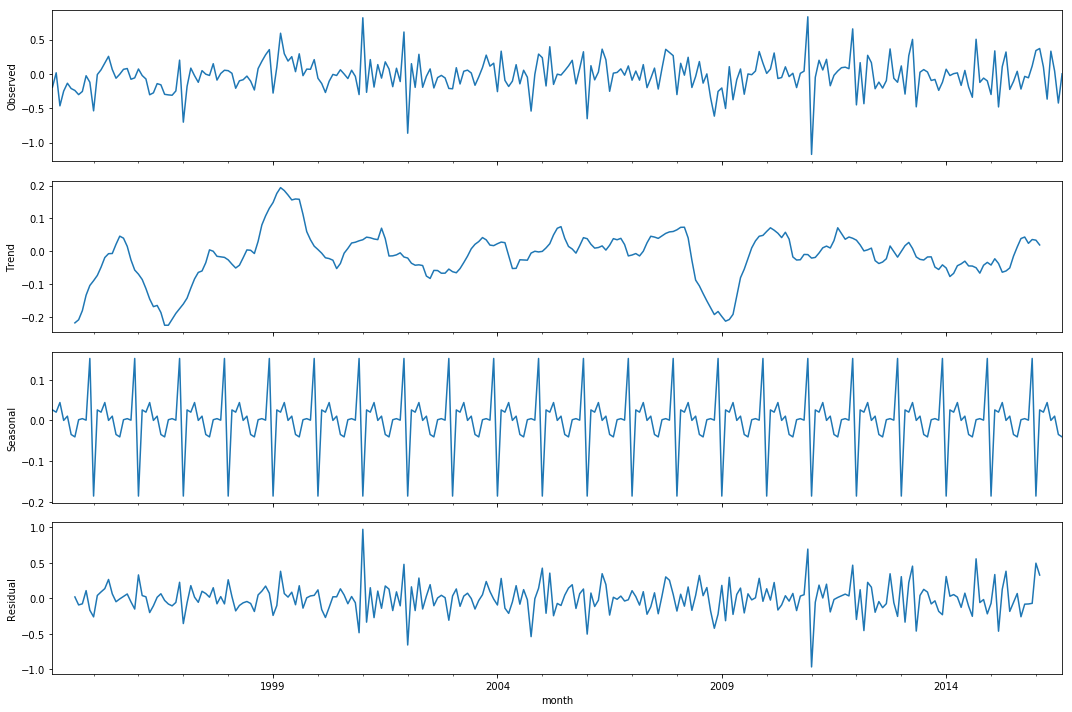

In [26]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(russia.diff13.dropna()).plot()

# Подбор Модели

Тренд колеблится у 0, значит начальное приближение для D=1,d=1

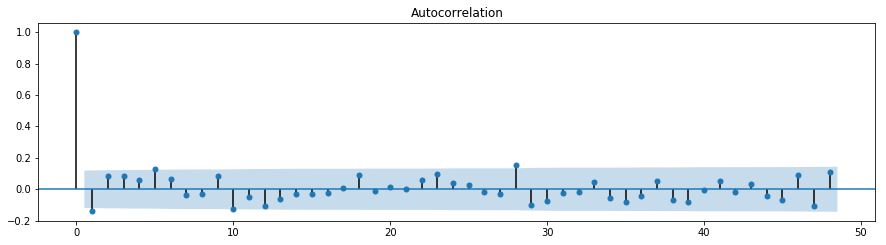

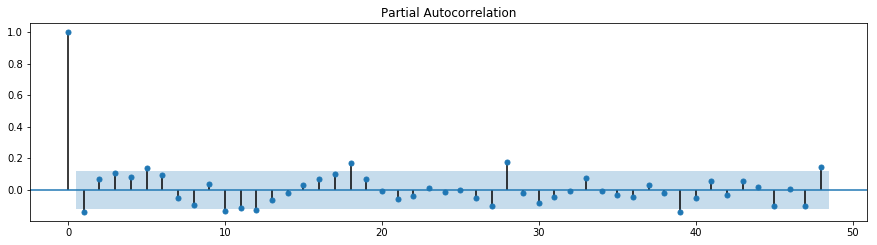

In [27]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(russia.diff13.dropna().values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(russia.diff13.dropna().values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения для P=1,p=1,Q=0,q=1

In [28]:
P=range(0,2)
p=range(0,2)
Q=0
q=range(0,2)
d=1
D=1

In [29]:
from itertools import product

In [32]:
parameters = product(p,q,P)
parameters_list = list(parameters)
len(parameters_list)

8

In [33]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(russia.box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, Q, 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 7.2 s


In [34]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters       aic
5  (1, 0, 1)  0.340521
3  (0, 1, 1)  1.170768
7  (1, 1, 1)  2.021912
4  (1, 0, 0)  2.625709
2  (0, 1, 0)  3.369832


Критерий Стьюдента: p=0.090796
Критерий Дики-Фуллера: p=0.000003


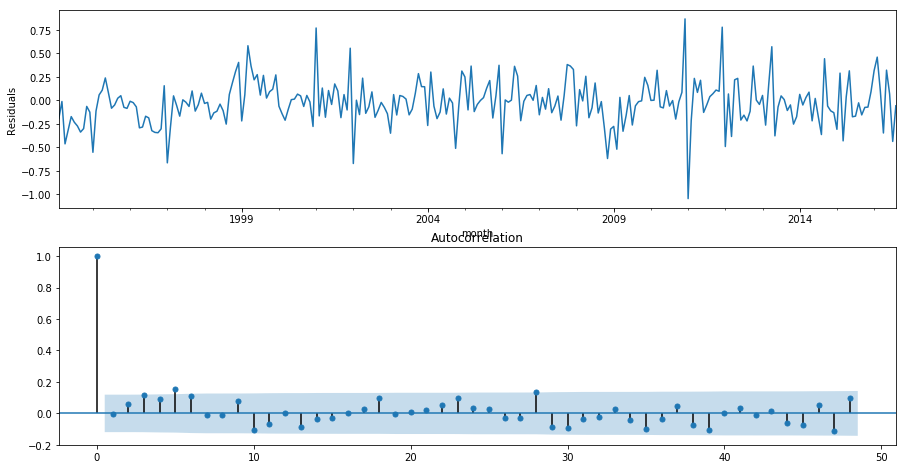

In [35]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается коррелограммой).

Посмотрим, насколько хорошо модель описывает данные:

In [36]:
def invboxcox(y,lmbda):
    if lmbda == 0:
          return(np.exp(y))
    else:
          return(np.exp(np.log(lmbda*y+1)/lmbda))

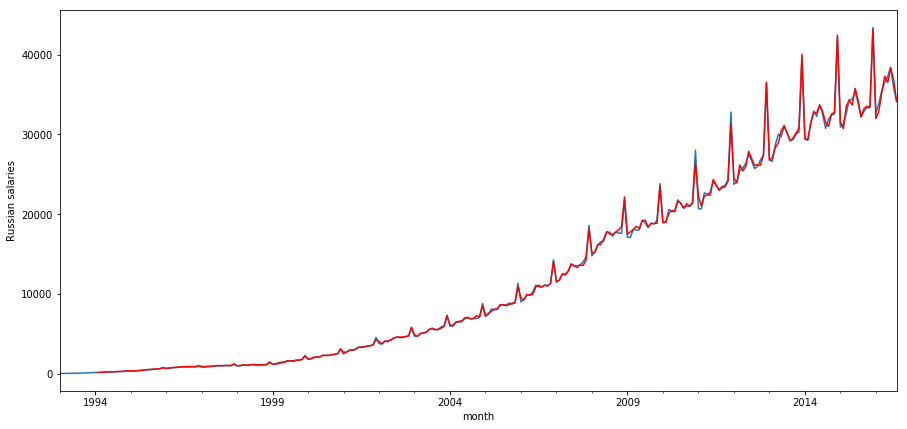

In [37]:
russia['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
russia.WAG_C_M.plot()
russia.model[13:].plot(color='r')
plt.ylabel('Russian salaries')
pylab.show()

Визуально модель очень хорошо описывает данные. Строим прогноз на 2 года.

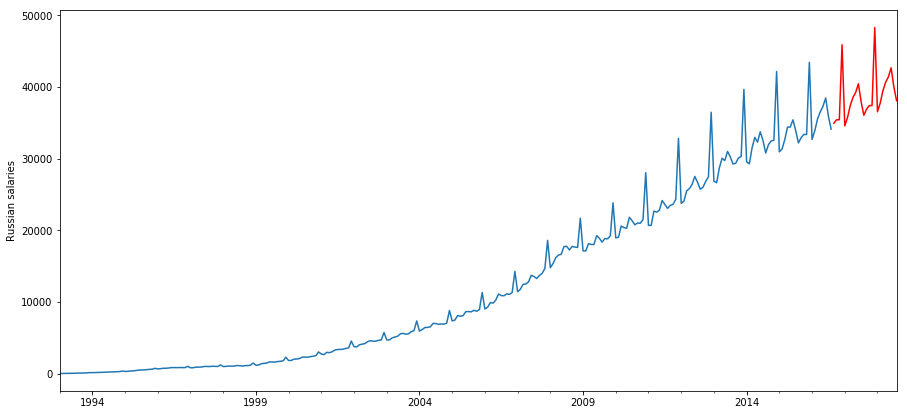

In [38]:
Russia = russia[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns=Russia.columns)
Russia = pd.concat([Russia, future])
Russia['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)
plt.figure(figsize(15,7))
Russia.WAG_C_M.plot()
Russia.forecast.plot(color='r')
plt.ylabel('Russian salaries')
pylab.show()
